In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('HEADING 2.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

# Check for missing values
print(df.isnull().sum())


500.075    0
500.336    0
500.597    0
500.858    0
501.119    0
          ..
950.048    0
950.286    0
950.524    0
950.763    0
SPAD       0
Length: 1793, dtype: int64


In [2]:
#Explore data statistics
df.describe()

500.075    500.336    500.597    500.858    501.119    501.381  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    5.470192   5.580514   5.628594   5.622908   5.570528   5.604774   
std     1.710088   1.744072   1.770647   1.772129   1.733025   1.748575   
min     2.265556   2.310000   2.287778   2.245556   2.254444   2.270000   
25%     3.946667   3.988889   3.971111   3.948889   3.967778   3.981111   
50%     5.746667   5.810000   5.823333   5.823333   5.776667   5.800000   
75%     6.690000   6.856667   6.933333   6.913333   6.826667   6.893333   
max     8.935000   9.120000   9.230000   9.200000   9.060000   9.125000   

         501.642    501.903    502.164    502.425  ...    948.856    949.094  \
count  81.000000  81.000000  81.000000  81.000000  ...  81.000000  81.000000   
mean    5.675967   5.691207   5.644328   5.661982  ...  35.602435  35.159657   
std     1.752539   1.724913   1.701916   1.729642  ...   8.323349   8.021139   
min     2.324444   2.381111   2.378889   2.348889  ...  21.360000  21.110000   
25%     4.060000   4.127778   4.110000   4.106667  ...  27.980000  27.823333   
50%     5.870000   5.926667   5.930000   5.933333  ...  34.323333  34.123333   
75%     6.950000   6.920000   6.816667   6.846667  ...  43.480000  42.643333   
max     9.220000   9.220000   9.130000   9.180000  ...  51.466667  50.456667   

         949.333    949.571    949.809    950.048    950.286    950.524  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean   35.294047  35.532908  35.398278  35.160110  35.268402  35.414472   
std     8.080048   8.319274   8.214227   7.998168   8.055461   8.245811   
min    21.090000  21.136667  21.073333  20.963333  21.043333  20.910000   
25%    27.930000  27.883333  27.960000  27.924444  27.996667  28.046667   
50%    34.066667  34.046667  34.000000  33.990000  34.093333  34.060000   
75%    42.880000  43.433333  43.200000  42.533333  42.640000  43.053333   
max    50.700000  51.420000  51.100000  50.493333  50.750000  51.223333   

         950.763       SPAD  
count  81.000000  81.000000  
mean   35.189870  36.115679  
std     8.064997   2.309925  
min    20.873333  30.900000  
25%    28.023333  34.500000  
50%    34.030000  36.200000  
75%    42.496667  38.000000  
max    50.713333  40.300000  

[8 rows x 1793 columns]

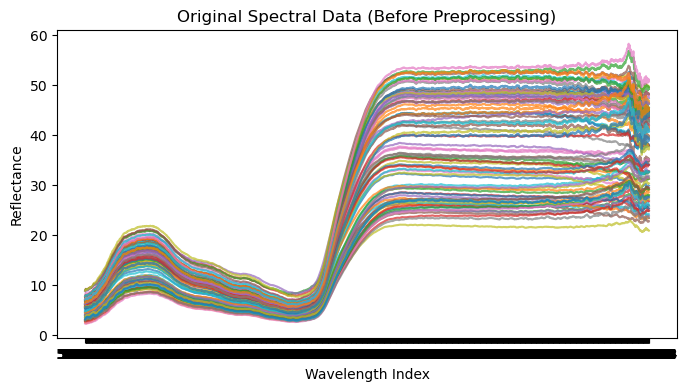

In [3]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 81
Number of outliers removed: 0
Cleaned dataset size: 81
Cleaned spectral data size: 81


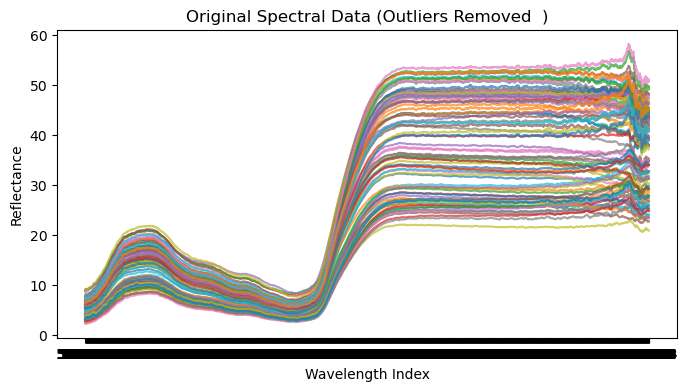

In [5]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T,alpha=0.7)
plt.title('Original Spectral Data (Outliers Removed  )')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

Correlation values with SPAD:
500.075   -0.623990
500.336   -0.625003
500.597   -0.629044
500.858   -0.631472
501.119   -0.633484
             ...   
949.809   -0.636060
950.048   -0.636408
950.286   -0.635924
950.524   -0.634188
950.763   -0.635919
Name: SPAD, Length: 1792, dtype: float64
Top features correlated with SPAD:
719.556    0.685163
722.846    0.685058
719.809    0.685025
718.796    0.684958
719.303    0.684900
722.593    0.684885
718.543    0.684884
723.605    0.684869
723.858    0.684827
716.517    0.684790
Name: SPAD, dtype: float64


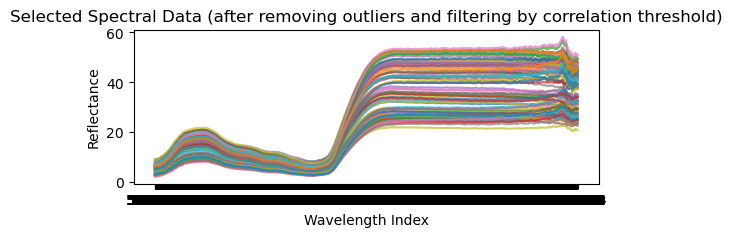

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.5
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]

# Step 8: Plot the selected features from the cleaned spectral data
plt.figure(figsize=(6, 2))
plt.plot(X_selected.T, alpha=0.7)
plt.title('Selected Spectral Data (after removing outliers and filtering by correlation threshold)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()


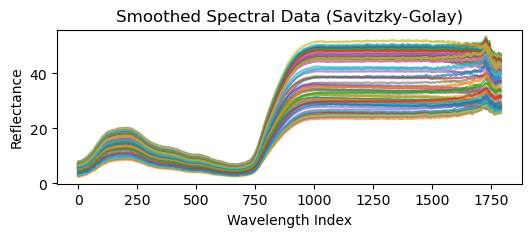

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

#Plot the smoothed spectral data
plt.figure(figsize=(6, 2))
plt.plot(spectral_sgm.T, alpha=0.7)  # Transpose for better plotting
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [8]:
#. Normalization and standardization
# Normalize spectral data
#normalizer = MinMaxScaler()
#spectral_normalized = normalizer.fit_transform(spectral_sgm)

#from sklearn.preprocessing import StandardScaler
# Then standardize
#scaler = StandardScaler()
#spectral_standardized = scaler.fit_transform(spectral_sgm)


In [9]:
# Apply PCA to determine the number of components to retain 95% variance
#pca = PCA()
#X_train_pca = pca.fit_transform(spectral_sgm)
#X_test_pca = pca.transform(spectral_sgm)
#explained_variance_ratio = pca.explained_variance_ratio_
#cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot
#plt.figure(figsize=(8, 4))
#plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual explained variance')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance Ratio')
#plt.legend()
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

# Choose number of components to retain 95% variance
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f"Number of components to retain 95% variance: {n_components}")

In [10]:
#from sklearn.decomposition import FastICA
from sklearn.decomposition import FastICA
#Assume spectral_sgm is your input data after preprocessing
ica = FastICA(n_components=5, max_iter=500, tol=0.01, random_state=175)

# Apply ICA to the spectral data
X_ica = ica.fit_transform(spectral_sgm)

# Check the shape of the transformed data
print(f"Shape of ICA-transformed data: {X_ica.shape}")


Shape of ICA-transformed data: (81, 5)


In [11]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica,cleaned_spad_data, test_size=0.20, random_state=175)

In [12]:
from scipy.stats import pearsonr
import numpy as np

# Pearson Correlation for Feature Selection
def select_features_pearson(X_train, y_train, threshold=0.1):
    # Calculate Pearson correlation for each feature in X_train with y_train
    correlations = np.array([pearsonr(X_train[:, i], y_train)[0] for i in range(X_train.shape[1])])
    
    # Select indices of features with absolute correlation greater than threshold
    selected_features = np.where(np.abs(correlations) > threshold)[0]
    
    # Return the filtered training set and the indices of selected features
    return X_train[:, selected_features], selected_features

# Apply Pearson Correlation for Feature Selection
threshold = 0.1  # Adjust the threshold as needed
X_train_pearson, selected_features = select_features_pearson(X_train, y_train, threshold)

# Apply the same feature selection to X_test
X_test_pearson = X_test[:, selected_features]

# Output
print(f"Number of features selected by Pearson correlation: {len(selected_features)}")
print("Selected features indices (Pearson):", selected_features)


Number of features selected by Pearson correlation: 5
Selected features indices (Pearson): [0 1 2 3 4]


In [26]:
# Define parameter grids for RandomizedSearchCV
param_dist_rf = {
   'n_estimators': [300,100,950,700],
    'max_depth': [100,1,30,20],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [10,3,5,6,7],
    'bootstrap': [True, False]
}
# Initialize models
model_rf = RandomForestRegressor(random_state=121)

# Perform RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_rf.fit(X_train_pearson, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)
# Cross-validation with the best hyperparameters for each model
mse_scores_rf = cross_val_score(best_rf, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_rf = -mse_scores_rf
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate the individual models
models = {
    "RandomForest": best_rf
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 950, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 30, 'bootstrap': False}
Average MSE for Random Forest: 2.3521095643976704
Evaluating RandomForest model...
Training Metrics:
                   MAE       MSE  Pearson        R2      RMSE       RPD
RandomForest  1.047884  1.786706  0.79413  0.630642  1.336677  1.645418

Testing Metrics:
                   MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.413195  2.751879  0.792702  0.596333  1.658879  1.573941


In [43]:
# Define parameter grids for RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [30,50,10,40],
    'learning_rate': [0.01, 0.1,1,0.001],
    'max_depth': [3, 5, 8, 12],
    'subsample': [0.6, 0.4, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
# Initialize models
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=175)
# Perform RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_dist_xgb, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_xgb.fit(X_train_pearson, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)
# Cross-validation with the best hyperparameters for each model
mse_scores_xgb = cross_val_score(best_xgb, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_xgb = -mse_scores_xgb
average_mse_xgb = np.mean(mse_scores_xgb)
# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")


# Evaluate the individual models
models = {
      "XGBoost": best_xgb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 1.0, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Average MSE for XGBoost: 2.538012370832155
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE     RPD
XGBoost  0.520693  0.387366  0.972308  0.919921  0.622387  3.5338

Testing Metrics:
              MAE       MSE   Pearson       R2      RMSE       RPD
XGBoost  1.602697  3.389444  0.733714  0.50281  1.841044  1.418204


In [45]:
# Define parameter grids for RandomizedSearchCV
param_dist_gb = {
    'n_estimators': [100,200,500,400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1,3, 6, 9, 12]
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=64, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_pearson, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.01}
Average MSE for Gradient Boosting: 3.0318027344391587
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  1.022247  1.587602  0.861755  0.671802  1.260001  1.745549

Testing Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  1.548226  3.258444  0.866898  0.522026  1.805116  1.446431


In [60]:
# Define parameter grids for RandomizedSearchCV
param_dist_svr = {
    'C': [0.5,4,10,100],
    'epsilon': [ 0.1, 1.8, 10,100],
    'kernel': ['linear', 'rbf']
}
# Initialize models
model_svr = SVR()
# Perform RandomizedSearchCV for each model
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=32, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_svr.fit(X_train_pearson, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)
# Cross-validation with the best hyperparameters for each model
mse_scores_svr = cross_val_score(best_svr, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_svr = -mse_scores_svr
average_mse_svr = np.mean(mse_scores_svr)
# Print cross-validation results
print(f"Average MSE for SVR: {average_mse_svr}")
# Evaluate the individual models
models = {
    "SVR": best_svr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for SVR:  {'kernel': 'rbf', 'epsilon': 0.1, 'C': 4}
Average MSE for SVR: 2.6787201216473595
Evaluating SVR model...
Training Metrics:
         MAE       MSE   Pearson       R2      RMSE     RPD
SVR  0.76721  1.127726  0.880137  0.76687  1.061944  2.0711

Testing Metrics:
          MAE      MSE   Pearson        R2      RMSE      RPD
SVR  1.529923  3.31523  0.735063  0.513696  1.820777  1.43399


In [68]:
# Define parameter grids for RandomizedSearchCV
param_dist_elnet = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1]
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_pearson, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 0.9, 'alpha': 0.01}
Average MSE for Elastic Net: 3.2430229643439867
Evaluating ElasticNet model...
Training Metrics:
                 MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  1.275922  2.537894  0.698673  0.475352  1.593077  1.380594

Testing Metrics:
                 MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  1.600967  3.953862  0.672282  0.420017  1.988432  1.313083


In [18]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=2) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_pearson, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 3.2433953195193768
Evaluating PLSR model...
Training Metrics:
          MAE       MSE   Pearson       R2      RMSE       RPD
PLSR  1.27438  2.462345  0.700693  0.49097  1.569186  1.401614

Testing Metrics:
           MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  1.569576  3.703001  0.681778  0.456815  1.924318  1.356832


In [19]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_pearson, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_pearson)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_pearson))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      0.988464
RMSE     0.994215
MAE      0.816793
R2       0.795659
RPD      2.212190
Pearson  0.919984

Ensemble Model Testing Metrics:
         Ensemble
MSE      3.328095
RMSE     1.824307
MAE      1.523552
R2       0.511809
RPD      1.431216
Pearson  0.749217


In [20]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_pearson, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_pearson)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_pearson))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      0.531832
RMSE     0.729268
MAE      0.572980
R2       0.890057
RPD      3.015890
Pearson  0.955515

Ensemble Model Testing Metrics:
         Ensemble
MSE      3.222843
RMSE     1.795228
MAE      1.521139
R2       0.527248
RPD      1.454398
Pearson  0.750190
